In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import newton, minimize, fsolve

In [2]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

In [3]:
b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 10, 101)
sol = odeint(pend, y0, t, args=(b, c))

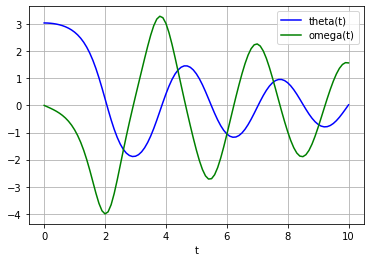

In [4]:
plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [5]:
def tRNA_charge(y, t, rates):
    k1, k_1, k2, k3, k4, k_4, k5 = rates
    T, S, E, ES, P, PT = y
    
    dTdt  = - k4*P*T + k_4*PT + k5*PT
    dSdt  = - k1*S*E + k_1*ES + k3*P   + k5*PT
    dEdt  = - k1*S*E + k_1*ES + k2*ES
    dESdt =   k1*E*S - k_1*ES - k2*ES
    dPdt  =   k2*ES  - k3*P   - k4*P*T + k_4*PT
    dPTdt =   k4*P*T - k_4*PT - k5*PT
    
    dydt = [dTdt, dSdt, dEdt, dESdt, dPdt, dPTdt]
    return dydt

In [6]:
def tRNA_charge_MM(y, t, const):
    Vmax, Km, S0, T0, k3, k5, T_Kd = const
    S = y
    # Assuming instantaneous equilibrium between
    # tRNA and EF-Tu:
    Ptot = S0 - S
    PT = Ptot/(1 + T_Kd/T0)
    P = Ptot - PT

    dSdt = - Vmax*S/(Km+S) + k3*P + k5*PT
    
    return dSdt

In [7]:
k1, k_1, k2, k3, k4, k_4, k5 = [1, 0.1, 1, 0.1, 1, 0.1, 0.01]
rates = (k1, k_1, k2, k3, k4, k_4, k5)

T0, S0, E0, ES0, P0, PT0 = [1000, 1, 0.2, 0, 0, 0]
y0 = [T0, S0, E0, ES0, P0, PT0]

t = np.linspace(0, 100, 10001)
sol = odeint(tRNA_charge, y0, t, args=(rates, ))

In [8]:
Vmax = k2*E0
Km = (k_1 + k2) / k1
T_Kd = k_4/k4
const = (Vmax, Km, S0, T0, k3, k5, T_Kd)

y0 = [S0]
sol_MM = odeint(tRNA_charge_MM, y0, t, args=(const, ))

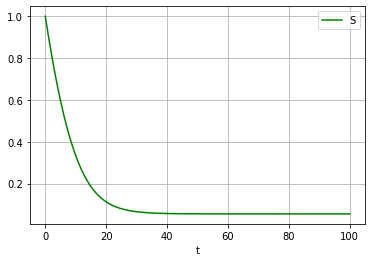

In [9]:
plt.plot(t, sol_MM[:, 0], 'g', label='S')
#plt.plot(t, sol_MM[:, 1], 'r', label='P')
plt.xlabel('t')
plt.legend(loc='best')
plt.grid()
plt.show()

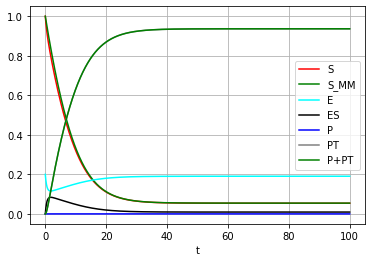

In [10]:
#plt.plot(t, sol[:, 0], 'g', label='T')
plt.plot(t, sol[:, 1], 'r', label='S')
plt.plot(t, sol_MM[:, 0], 'g', label='S_MM')
plt.plot(t, sol[:, 2], 'cyan', label='E')
plt.plot(t, sol[:, 3], 'black', label='ES')
plt.plot(t, sol[:, 4], 'b', label='P')
plt.plot(t, sol[:, 5], 'grey', label='PT')
plt.plot(t, sol[:, 4]+sol[:, 5], 'g', label='P+PT')
plt.xlabel('t')
plt.legend(loc='best')
plt.grid()
plt.show()

In [11]:
def tRNA_charge_MMn(y, t, Km_arr, S0_arr, const):
    # Multiple substrates with the same Vmax and EF-Tu Kd:
    def tRNA_i(i, y, Km_arr, S0_arr, const):
        Vmax, T0, k3, k5, T_Kd = const
        Si = y[i]
        Si0 = S0_arr[i]
        # Assuming instantaneous equilibrium between
        # tRNA and EF-Tu:
        Ptot = Si0 - Si
        PT = Ptot/(1 + T_Kd/T0)
        P = Ptot - PT
        # dSdt = - (Vmax * Si/Km_arr[i]) / (1 + sum(S0_arr[j]/Km_arr[j] * (Si/Si0)**(Km_arr[i]/Km_arr[j]) for j in range(len(y)))) + k3*P + k5*PT
        ds = 0
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            for j in range(len(y)):
                try:
                    ds += S0_arr[j]/Km_arr[j] * (Si/Si0)**(Km_arr[i]/Km_arr[j])
                except:
                    pass
        dSdt = - (Vmax * Si/Km_arr[i]) / (1 + ds) + k3*P + k5*PT
        
        
        return(dSdt)

    dydt = [tRNA_i(i, y, Km_arr, S0_arr, const) for i in range(len(y))]
    
    return dydt

In [12]:
Km_arr = [1.1, 20]
S0_arr = [25, 0.25]
const_n = (Vmax, T0, k3, k5, T_Kd)
t = np.linspace(0, 1000, 10001)

sol_MMn = odeint(tRNA_charge_MMn, S0_arr, t, args=(Km_arr, S0_arr, const_n, ))

In [13]:
sol_MMn

array([[25.        ,  0.25      ],
       [24.98086289,  0.24998947],
       [24.96174555,  0.24997894],
       ...,
       [ 7.57705113,  0.12545213],
       [ 7.57705106,  0.12545213],
       [ 7.57705099,  0.12545213]])

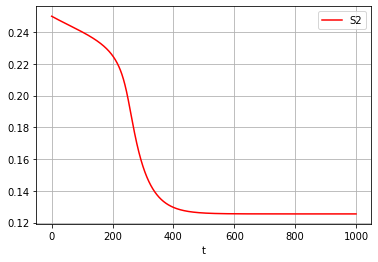

In [14]:
#plt.plot(t, sol_MMn[:, 0], 'g', label='S1')
plt.plot(t, sol_MMn[:, 1], 'r', label='S2')
#plt.plot(t, sol_MMn[:, 2], 'b', label='S3')
#plt.plot(t, sol_MMn[:, 3], 'cyan', label='S4')
plt.xlabel('t')
plt.legend(loc='best')
plt.grid()
plt.show()

In [15]:
def tRNA_charge_n(y, t, k1_arr, k_1_arr, rates):
    k2, k3, k4, k_4, k5 = rates
    T = y[-2]
    E = y[-1]
    dydt = list()
    
    N = (len(y)-2) // 4
    i = 0
    dTdt = 0
    dEdt = 0
    for n in range(0, N):
        # S, ES, P, PT
        S = y[i]
        ES = y[i+1]
        P = y[i+2]
        PT = y[i+3]
        k1 = k1_arr[n]
        k_1 = k_1_arr[n]
        
        dSdt  = - k1*S*E + k_1*ES + k3*P   + k5*PT
        dESdt =   k1*E*S - k_1*ES - k2*ES
        dPdt  =   k2*ES  - k3*P   - k4*P*T + k_4*PT
        dPTdt =   k4*P*T - k_4*PT - k5*PT
        dydt.extend([dSdt, dESdt, dPdt, dPTdt])
        
        dTdt  += - k4*P*T + k_4*PT + k5*PT
        dEdt  += - k1*S*E + k_1*ES + k2*ES
        
        i += 4
    dydt.extend([dTdt, dEdt])
    
    return dydt

In [16]:
# k3 => 4.5 min half-life from Wolfson et al. 2002
# k5 => >100 min half-life from Wolfson et al. 2002
# k4 => k_on=1e5 for EF-Tu binding from LaRiviere et al. 2001 (this is constant)
# k_4 => k_off=0.1 for EF-Tu binding from LaRiviere et al. 2001 (this is variable, but likely a lot higher)
# k2 => kcat for irreversible aminoacylation from en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics (this should be constant regardless of tRNA since the catalytic context is the same due to CCA-ending)
# k2 = 7 # 1/s
k2 = 60 # 1/s (this is adjusted to Wolfson et al. 2002 data)
k3 = 0.693/(4.5*60) # 1/s
k4 = 1e5 # 1/(M*s)
k_4 = 0.1 # 1/s
k5 = 0.693/(100*60) # 1/s
rates = (k2, k3, k4, k_4, k5)

# Km ~ 10 uM from Wolfson et al. 2002, can decrease >2000 fold with mutations
# k1 => k_on=1e6 binding to the enzyme
# k_1 => k_off=3 unbinding to the enzyme
k1_arr = [1e7, 1e6, 1e5, 4e4]
k_1_arr = [40, 400, 800, 1000]

# Starting concentration of tRNAs:
S0_arr = np.array([1, 0.75, 2, 0.5])*1e-6
y0 = [s0 if i==0 else 0 for s0 in S0_arr for i in range(4)]
# EF-Tu in 3x compared to tRNA, enzyme in 1/100x compared to tRNA:
T0, E0 = sum(S0_arr)*3, sum(S0_arr)/400
y0.extend([T0, E0])

t = np.linspace(0, 20000, 100001)
sol2 = odeint(tRNA_charge_n, y0, t, args=(k1_arr, k_1_arr, rates))

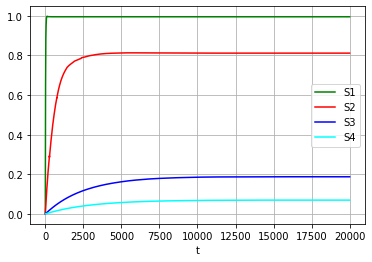

In [17]:
plt.plot(t, (sol2[0, 0] - sol2[:, 0])/sol2[0, 0], 'g', label='S1')
plt.plot(t, (sol2[0, 4] - sol2[:, 4])/sol2[0, 4], 'r', label='S2')
plt.plot(t, (sol2[0, 8] - sol2[:, 8])/sol2[0, 8], 'b', label='S3')
plt.plot(t, (sol2[0, 12] - sol2[:, 12])/sol2[0, 12], 'cyan', label='S4')
plt.xlabel('t')
plt.legend(loc='best')
plt.grid()
plt.show()

In [18]:
np.array(Km_arr)/Km_arr[0]

array([ 1.        , 18.18181818])

In [19]:
Km_arr = [(ki_1 + k2) / ki1 for ki1, ki_1 in zip(k1_arr, k_1_arr)]
Vmax = k2*E0
T_Kd = k_4/k4
const_n = (Vmax, T0, k3, k5, T_Kd)

sol_MMn = odeint(tRNA_charge_MMn, S0_arr, t, args=(Km_arr, S0_arr, const_n, ))

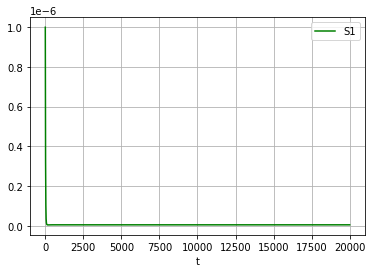

In [20]:
plt.plot(t, sol_MMn[:, 0], 'g', label='S1')
#plt.plot(t, sol_MMn[:, 1], 'r', label='S2')
#plt.plot(t, sol_MMn[:, 2], 'b', label='S3')
#plt.plot(t, sol_MMn[:, 3], 'cyan', label='S3')
plt.xlabel('t')
plt.legend(loc='best')
plt.grid()
plt.show()

In [21]:
def tRNA_charge_n(y, t, k1_arr, k_1_arr, rates):
    # Vectorized solution #
    # Ordered as: S, ES, P, PT
    # Finished by: T and E
    k2, k3, k4, k_4, k5 = rates
    T = y[-2]
    E = y[-1]
    dydt = np.zeros(len(y))
    dydt[0:-2:4] = - k1_arr*y[0:-2:4]*E + k_1_arr*y[1:-2:4] + k3*y[2:-2:4]   + k5*y[3:-2:4]
    dydt[1:-2:4] =   k1_arr*y[0:-2:4]*E - k_1_arr*y[1:-2:4] - k2*y[1:-2:4]
    dydt[2:-2:4] =   k2*y[1:-2:4]   - k3*y[2:-2:4]  - k4*y[2:-2:4]*T + k_4*y[3:-2:4]
    dydt[3:-2:4] =   k4*y[2:-2:4]*T - k_4*y[3:-2:4] - k5*y[3:-2:4]
    dydt[-2] = np.sum(- k4*y[2:-2:4]*T + k_4*y[3:-2:4] + k5*y[3:-2:4])
    dydt[-1] = np.sum(- k1_arr*y[0:-2:4]*E + k_1_arr*y[1:-2:4] + k2*y[1:-2:4])
    
    return(dydt)

In [657]:

N_tRNAs = 10

# k3 => 4.5 min half-life from Wolfson et al. 2002
# k5 => >100 min half-life from Wolfson et al. 2002
# k4 => k_on=1e5 for EF-Tu binding from LaRiviere et al. 2001 (this is constant)
# k_4 => k_off=0.1 for EF-Tu binding from LaRiviere et al. 2001 (this is variable, but likely a lot higher)
# k2 => kcat for irreversible aminoacylation from en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics (this should be constant regardless of tRNA since the catalytic context is the same due to CCA-ending)
# k2 = 7 # 1/s
k2 = 60 # 1/s (this is adjusted to Wolfson et al. 2002 data)
k3 = 0.693/(4.5*60) # 1/s
k4 = 1e5 # 1/(M*s)
k_4 = 0.1 # 1/s
k5 = 0.693/(100*60) # 1/s
rates = np.array([k2, k3, k4, k_4, k5])

# Km ~ 10 uM from Wolfson et al. 2002, can decrease >2000 fold with mutations
# k1 => k_on=1e6 binding to the enzyme
# k_1 => k_off=3 unbinding to the enzyme
k1_arr_obs = np.linspace(1e7, 4e4, N_tRNAs)
# k1_arr_obs = np.linspace(1e7, 1e7, N_tRNAs)
k_1_arr_obs = np.linspace(40, 40, N_tRNAs)
# k_1_arr_obs = np.linspace(40, 40, N_tRNAs)
if False:
    k1_arr = [k1i for i in range(N_tRNAs) for k1i in k1_arr_obs]
    k1_arr = np.array(k1_arr)
    k_1_arr = [k_1i for k_1i in k_1_arr_obs for i in range(N_tRNAs)]
    k_1_arr = np.array(k_1_arr)
    # Starting concentration of tRNAs:
    S0_arr = np.random.normal(1, 0.2, N_tRNAs**2)
    S0_arr[S0_arr < 0] = 1
    S0_arr *= 1e-6
else:
    k1_arr = np.random.choice(k1_arr_obs, N_tRNAs, replace=False)
    k_1_arr = np.random.choice(k_1_arr_obs, N_tRNAs, replace=False)
    # Starting concentration of tRNAs:
    S0_arr = np.random.normal(1, 0.2, N_tRNAs)
    S0_arr[S0_arr < 0] = 1
    S0_arr *= 1e-6
y0 = [s0 if i==0 else 0 for s0 in S0_arr for i in range(4)]
# EF-Tu in 3x compared to tRNA, enzyme in 1/100x compared to tRNA:
T0, E0 = sum(S0_arr)*0, sum(S0_arr)/400
y0.extend([T0, E0])
y0 = np.array(y0)

# t = np.linspace(0, 60*62, 10000)
t = np.logspace(0, 14, 10000, base=2)
sol2 = odeint(tRNA_charge_n, y0, t, args=(k1_arr, k_1_arr, rates))

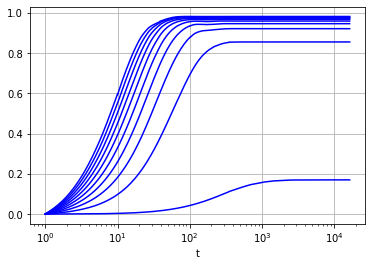

In [658]:
for n in range((sol2.shape[1]-2)//4):
    plt.plot(t, (sol2[0, n*4] - sol2[:, n*4])/sol2[0, n*4], 'b')
plt.xlabel('t')
plt.xscale('log')
plt.grid()
plt.show()

In [659]:
t, sol_n1 = sol_p3_n_on(k1_arr, S0_arr)

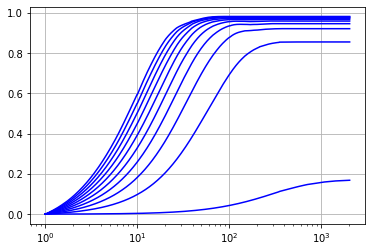

In [660]:
for i in range(0, sol_n1.shape[1]-1, 3):
    plt.plot(t, sol_n1[:, i+2]/sol_n1[0, i], 'b')
plt.xscale('log')
plt.grid()


In [900]:
Km_arr = [(ki_1 + k2) / ki1 for ki1, ki_1 in zip(k1_arr, k_1_arr)]
Vmax = k2*E0
T_Kd = k_4/k4
const_n = (Vmax, T0, k3, k5, T_Kd)

sol_MMn = odeint(tRNA_charge_MMn, S0_arr, t, args=(Km_arr, S0_arr, const_n, ))

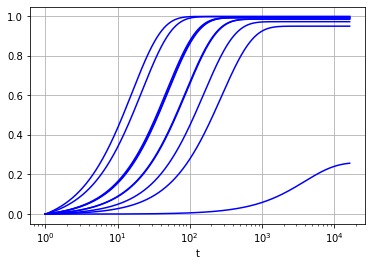

In [901]:
for n in range(sol_MMn.shape[1]):
    plt.plot(t, (sol_MMn[0, n] - sol_MMn[:, n])/sol_MMn[0, n], 'b')
plt.xlabel('t')
plt.xscale('log')
plt.grid()
plt.show()

In [169]:

# k3 => 4.5 min half-life from Wolfson et al. 2002
# k5 => >100 min half-life from Wolfson et al. 2002
# k4 => k_on=1e5 for EF-Tu binding from LaRiviere et al. 2001 (this is constant)
# k_4 => k_off=0.1 for EF-Tu binding from LaRiviere et al. 2001 (this is variable, but likely a lot higher)
# k2 => kcat for irreversible aminoacylation from en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics (this should be constant regardless of tRNA since the catalytic context is the same due to CCA-ending)

k1_arr = np.array([1e7])
k_1_arr = np.array([40])
k2 = 60 # 1/s (this is adjusted to Wolfson et al. 2002 data)
k3 = 0.693/(4.5*60) # 1/s
k4 = 1e5 # 1/(M*s)
k_4 = 0.1 # 1/s
k5 = 0.693/(100*60) # 1/s
rates = np.array([k2, k3, k4, k_4, k5])

    
S0_arr = np.array([1e-6])    
# EF-Tu in 3x compared to tRNA, enzyme in 1/100x compared to tRNA:
T0, E0 = sum(S0_arr)*3, sum(S0_arr)/100

y0 = [s0 if i==0 else 0 for s0 in S0_arr for i in range(4)]
y0.extend([T0, E0])
y0 = np.array(y0)

# t = np.linspace(0, 60*62, 10000)
t = np.logspace(0, 10, 10000, base=2)
sol2 = odeint(tRNA_charge_n, y0, t, args=(k1_arr, k_1_arr, rates))

In [170]:
sol2.shape

(10000, 6)

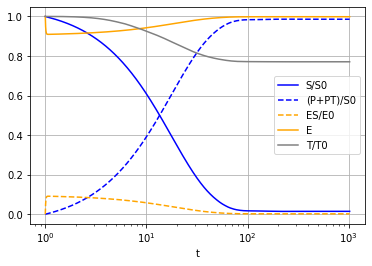

In [171]:
# Ordered as: S, ES, P, PT
# Finished by: T and E


plt.plot(t, sol2[:, 0]/sol2[0, 0], c='b', label='S/S0')
plt.plot(t, (sol2[:, 2]+sol2[:, 3])/sol2[0, 0], c='b', ls='--', label='(P+PT)/S0')
plt.plot(t, sol2[:, 1]/sol2[0, 5], c='orange', ls='--', label='ES/E0')
plt.plot(t, sol2[:, 5]/sol2[0, 5], c='orange', label='E/E0')
plt.plot(t, sol2[:, 4]/sol2[0, 4], c='grey', label='T/T0')

plt.xlabel('t')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

In [172]:
def tRNA_charge_p3_n(y, t, k1_arr, k_1_arr, rates):
    # Vectorized solution #
    # Ordered as: S, ES, P
    # Finished by: E
    k2, k3 = rates
    E = y[-1]
    dydt = np.zeros(len(y))
    dydt[0:-1:3] = - k1_arr*y[0:-1:3]*E + k_1_arr*y[1:-1:3] + k3*y[2:-1:3]
    dydt[1:-1:3] =   k1_arr*y[0:-1:3]*E - k_1_arr*y[1:-1:3] - k2*y[1:-1:3]
    dydt[2:-1:3] =   k2*y[1:-1:3]       - k3*y[2:-1:3]
    dydt[-1] = np.sum(- k1_arr*y[0:-1:3]*E + k_1_arr*y[1:-1:3] + k2*y[1:-1:3])
    
    return(dydt)

In [329]:
# k3 => 4.5 min half-life from Wolfson et al. 2002
# k5 => >100 min half-life from Wolfson et al. 2002
# k4 => k_on=1e5 for EF-Tu binding from LaRiviere et al. 2001 (this is constant)
# k_4 => k_off=0.1 for EF-Tu binding from LaRiviere et al. 2001 (this is variable, but likely a lot higher)
# k2 => kcat for irreversible aminoacylation from en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics (this should be constant regardless of tRNA since the catalytic context is the same due to CCA-ending)

k1_arr = np.array([10, 2])
k_1_arr = np.array([40, 40])
k2 = 60 # 1/s (this is adjusted to Wolfson et al. 2002 data)
k3 = 0.693/(4.5*60) # 1/s
rates = np.array([k2, k3])


S0_arr = np.array([5, 5])    
E0 = sum(S0_arr)/1000

y0 = [s0 if i==0 else 0 for s0 in S0_arr for i in range(3)]
y0.extend([E0])
y0 = np.array(y0)

t = np.linspace(0, 120, 10000)
# t = np.logspace(0, 10, 10000, base=2)
sol3 = odeint(tRNA_charge_p3_n, y0, t, args=(k1_arr, k_1_arr, rates))

In [330]:
(k_1_arr[0]+k2)/k1_arr[0]

10.0

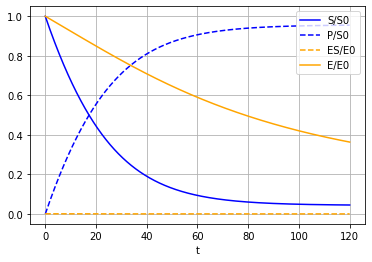

In [331]:

plt.plot(t, sol3[:, 0]/sol3[0, 0], c='b', label='S/S0')
plt.plot(t, sol3[:, 2]/sol3[0, 0], c='b', ls='--', label='P/S0')
plt.plot(t, sol3[:, 1]/sol3[0, 3], c='orange', ls='--', label='ES/E0')
plt.plot(t, sol3[:, 3]/sol3[0, 3], c='orange', label='E/E0')

plt.xlabel('t')
#plt.xscale('log')
#plt.xlim((1, max(t)))
plt.legend()
plt.grid()
plt.show()

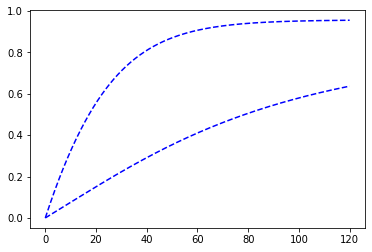

In [334]:
plt.plot(t, sol3[:, 2]/sol3[0, 0], c='b', ls='--', label='P1/S0')
plt.plot(t, sol3[:, 5]/sol3[0, 3], c='b', ls='--', label='P2/S0')

In [670]:
def sol_p3_n_on(k1_arr, S0_arr):
    k_1_arr = np.array([40]*len(k1_arr))
    k2 = 60 # 1/s (this is adjusted to Wolfson et al. 2002 data)
    k3 = 0.693/(4.5*60) # 1/s
    rates = np.array([k2, k3])


    # S0_arr = np.array([10/len(k1_arr)]*len(k1_arr))    
    E0 = sum(S0_arr)/400

    y0 = [s0 if i==0 else 0 for s0 in S0_arr for i in range(3)]
    y0.extend([E0])
    y0 = np.array(y0)

    # t = np.linspace(0, 120, 10000)
    t = np.logspace(0, 11, 1000, base=2)
    sol = odeint(tRNA_charge_p3_n, y0, t, args=(k1_arr, k_1_arr, rates))
    
    return(t, sol)

In [690]:
Nt = 100
max_k1 = 2000
k1_arr = np.linspace(1, max_k1, Nt)
S0_arr = np.random.normal(1, 0.5, Nt)
S0_arr[S0_arr<0.1] = 1
S0_arr /= (10*Nt)
t, sol_n10 = sol_p3_n_on(k1_arr, S0_arr)

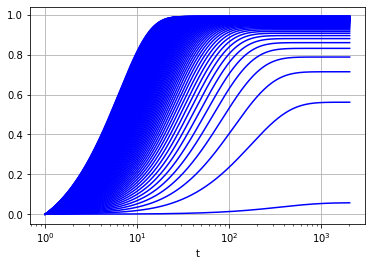

In [691]:
for i in range(0, sol_n10.shape[1]-1, 3):
    plt.plot(t, sol_n10[:, i+2]/sol_n10[0, i], 'b')

plt.xlabel('t')
plt.xscale('log')
plt.grid()
plt.show()

In [720]:
# Objective function:
def obj_fun(P_S0, S0_arr, p):
    t, sol_i = sol_p3_n_on(p, S0_arr)
    P_S0_i = sol_i[:, 2:-1:3]/sol_i[0, 0:-1:3]
    loss = np.sum(np.power(P_S0 - P_S0_i, 2))
    return(loss)


P_S0 = sol_n10[:, 2:-1:3]/sol_n10[0, 0:-1:3]
# bnds = ((0.1, 1000), )*10
bnds = tuple([(i, j) if i>0 else (0.1, j) for i, j in zip(np.linspace(1, max_k1, Nt)-5, np.linspace(1, max_k1, Nt)+5)])
#guess = tuple(np.linspace(1, 100, 10))
# guess = (50, )*10
guess = tuple([np.random.choice([i, j]) for i, j in bnds])
def min_fun(p): return(obj_fun(P_S0, S0_arr, p))
p_fun = minimize(min_fun, guess, method='Powell', bounds=bnds, tol=1)
# method='Powell' <- slow but gets to the correct result
# method='L-BFGS-B' <- faster but stops too early

In [721]:
p_fun

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.01420445762348525
       x: [ 1.151e+00  2.116e+01 ...  1.980e+03  2.000e+03]
     nit: 3
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 7.852e-02  1.028e+00 ...  8.576e-02 -1.092e+00]]
    nfev: 1807

In [722]:
sorted(p_fun.x)

[1.1505289006088606,
 21.1601425304104,
 41.4632639345259,
 61.64976976433936,
 81.71598154500728,
 101.90615612115334,
 122.09703966016875,
 142.28845314277916,
 162.60262091471685,
 182.79353131793238,
 202.86298599296367,
 223.05605611254785,
 243.24799414911303,
 263.44070372265696,
 283.63551585262377,
 303.94899502664924,
 324.1405892509519,
 344.33269078997773,
 364.40181125899517,
 384.71735174305,
 404.78608794557175,
 425.10177744609854,
 445.29409945279895,
 465.484718105549,
 485.67705966101744,
 505.74718851275406,
 526.0611125715213,
 546.2515009508691,
 566.3237211594059,
 586.63911597868,
 606.8325150746814,
 627.0200347844451,
 647.0916912799757,
 667.2842327459671,
 687.5984563063016,
 707.791308095463,
 727.980839115665,
 748.0502088916598,
 768.2496363584762,
 788.4413361482009,
 808.7534069822206,
 828.8258774687988,
 849.0168000690973,
 869.2135513024505,
 889.4022016818373,
 909.596396464492,
 929.9180570226474,
 950.1053195462388,
 970.2945785387947,
 990.375074

In [723]:
list(k1_arr)

[1.0,
 21.19191919191919,
 41.38383838383838,
 61.57575757575757,
 81.76767676767676,
 101.95959595959596,
 122.15151515151514,
 142.34343434343432,
 162.53535353535352,
 182.72727272727272,
 202.91919191919192,
 223.1111111111111,
 243.30303030303028,
 263.4949494949495,
 283.68686868686865,
 303.8787878787879,
 324.07070707070704,
 344.2626262626262,
 364.45454545454544,
 384.6464646464646,
 404.83838383838383,
 425.030303030303,
 445.2222222222222,
 465.4141414141414,
 485.60606060606057,
 505.79797979797974,
 525.989898989899,
 546.1818181818181,
 566.3737373737373,
 586.5656565656565,
 606.7575757575758,
 626.9494949494949,
 647.1414141414141,
 667.3333333333333,
 687.5252525252524,
 707.7171717171717,
 727.9090909090909,
 748.10101010101,
 768.2929292929292,
 788.4848484848484,
 808.6767676767677,
 828.8686868686868,
 849.060606060606,
 869.2525252525252,
 889.4444444444443,
 909.6363636363635,
 929.8282828282828,
 950.020202020202,
 970.2121212121211,
 990.4040404040403,
 1010.5

In [724]:
obj_fun(P_S0, S0_arr, k1_arr)

0.0

In [725]:
obj_fun(P_S0, S0_arr, p_fun.x)

0.01420445762348525

In [726]:
t, sol_n10_inf = sol_p3_n_on(p_fun.x, S0_arr)
P_S0_inf = sol_n10_inf[:, 2:-1:3]/sol_n10_inf[0, 0:-1:3]
np.sum(np.power(P_S0 - P_S0_inf, 2))

0.01420445762348525

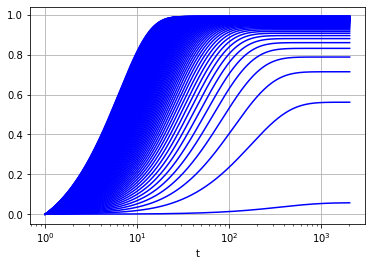

In [727]:
for i in range(0, sol_n10.shape[1]-1, 3):
    plt.plot(t, sol_n10[:, i+2]/sol_n10[0, i], 'b')

plt.xlabel('t')
plt.xscale('log')
plt.grid()
plt.show()

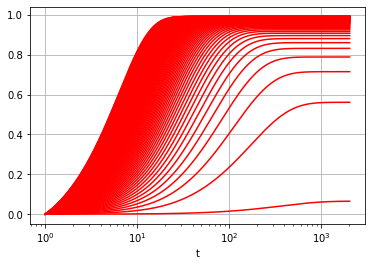

In [728]:
for i in range(0, sol_n10_inf.shape[1]-1, 3):
    plt.plot(t, sol_n10_inf[:, i+2]/sol_n10_inf[0, i], 'r')

plt.xlabel('t')
plt.xscale('log')
plt.grid()
plt.show()

In [372]:
obj_fun(P_S0, [10, 2])

6589.937702284221

In [322]:
SSE = np.zeros((30, 30))
Km = list()
SSE_list = list()
for i, k1 in enumerate(np.linspace(3, 20, 30)):
    for j, k_1 in enumerate(np.linspace(30, 100, 30)):
        SSE[i, j] = obj_fun(P_S0, [k1, k_1])
        Km.append(k_1/k1)
        SSE_list.append(SSE[i, j])
        

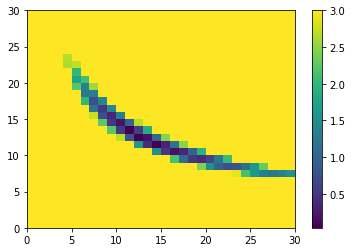

In [326]:
#plt.pcolormesh(np.log10(SSE), vmax=2)
plt.pcolormesh(SSE, vmax=3)
#plt.plot(x,y,'ro')
plt.colorbar()
plt.show()

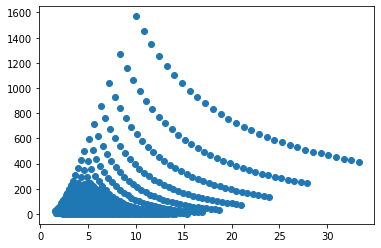

In [327]:
plt.scatter(Km, SSE_list)